In [2]:
import os
import json
import hashlib
from datetime import datetime
from PIL import Image, PngImagePlugin

import unibox as ub
logger = ub.UniLogger()


gpt2 client:

In [3]:
# gpt2 api
from gradio_client import Client

def get_gpt2_pred_old(client, prompt:str, max_length:int, models:list[str]):
	# prompt: str
	# max_length: float (numeric value between 10 and 300)
	# return: str
	result = client.predict(
		prompt,
		max_length,
		models,
		api_name="/predict"
	)
	return result





def get_gpt2_pred(client, rating:str, character:str, prompt:str, max_length:int, models:list[str]):
	
	assert rating in ['general','nsfw']
	
	result = client.predict(
			rating,	# Literal['safe', 'sensitive', 'nsfw', 'nsfw, explicit'] in 'Rating' Radio component
			"2020s",	# Literal['2000s', '2010s', '2015s', '2020s'] in 'Date' Radio component
			"excellent",	# Literal['bad', 'normal', 'good', 'excellent'] in 'Quality' Radio component
			character,	# str in 'Character' Textbox component
			prompt,	# str in 'prompt' Textbox component
			max_length,	# float (numeric value between 40 and 300) in 'max_length' Slider component
			models,	# List[Literal['checkpoint-e0_s12000', 'checkpoint-e0_s28000', 'checkpoint-e0_s48000']] in 'Select Models' Checkboxgroup component
			api_name="/predict"
	)
	return result


# GPT2_ENDPOINT = "https://ab2b7e0b874cc07fb9.gradio.live/"
# client = Client(GPT2_ENDPOINT) # version epoch_0_batch_11727
# get_gpt2_pred(client, "hatsune miku", 100, ["epoch_0_batch_17619"])

webui:

In [4]:
# https://github.com/troph-team/eval-it/blob/aa0cb59983e2b0385ef03328b2ce6a3c36a073a0/evalit/webui/webui_t2i_client.py#L38C7-L38C27
from evalit.webui.webui_t2i_client import WebuiT2iClient
from evalit.webui.webui_t2i_client import WebuiT2iClient, SdxlGenerationConfig
from evalit.webui.webui_options_manager import OptionsManager


def save_image(image_paths:list[str], param_strs:list[str], api_args, save_dir:str="saved_images"):
    """保存一个webui生成结果到本地 (可能包括多张图)

    """

    saved_files = []

    for i, (image, param) in enumerate(zip(image_paths, param_strs)):
        os.makedirs(save_dir, exist_ok=True)
        pnginfo = PngImagePlugin.PngInfo()
        pnginfo.add_text("parameters", param)
        pnginfo.add_text("api_args", json.dumps(api_args))

        # get filename
        timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
        img_hash = hashlib.md5(image.tobytes()).hexdigest()        
        file_name = f"{timestamp}_{img_hash[:4]}.png"        
        file_path = os.path.join(save_dir, file_name)

        # save file
        image.save(file_path, pnginfo=pnginfo)
        saved_files.append(file_path)  # Add the saved file path to the list

    return saved_files

def generate_and_save_images(prompt:str, config:SdxlGenerationConfig, save_dir:str="saved_images",):
    """从webui api roll图, 然后返回本地保存路径
    (假设模型已经在webui里手动调到需要的那个)
    """
    # initialize client
    client = WebuiT2iClient(baseurl="http://0.0.0.0:7862")

    # initialize options manager
    client_base_url = client.baseurl
    options_manager = OptionsManager(client_base_url)


    # generate images
    images, param_strs, api_args = client.generate(prompt, config)  # negative defined in config

    # save images
    saved_files = save_image(images, param_strs, api_args, save_dir) # list of paths to saved images
    return saved_files

# save_dir = "saved_images"
# img_path = generate_and_save_images("a cat")[0]
# display(ub.loads(img_path))

gradio:

In [38]:
import gradio as gr
from PIL import Image
import random
import timeit


def get_sdxl_generation_config(steps:int=24):
    """returns a SdxlGenerationConfig object with modifiable steps param
    """
    
    # SDXL generation config
    # https://github.com/troph-team/eval-it/blob/aa0cb59983e2b0385ef03328b2ce6a3c36a073a0/evalit/webui/webui_t2i_client.py#L38  
    config = SdxlGenerationConfig() 
    config.sampler_name="Euler a"
    config.cfg_scale=6.5
    config.height=1280
    config.width=768
    config.steps=steps

    return config


def roll_image(prompt:str, character:str = "", rating:str="general", img_steps:int=24, prompt_only:bool=False):
    
    # rating = random.choice(["general", "nsfw"])    
    prompt_len = 200
    # img_steps = 28

    # get sdxl config
    config = get_sdxl_generation_config(steps=img_steps)
    
    orig_prompt = prompt
    logger.info(f"got prompt: {prompt} | character: {character} | rating: {rating}")

    # get gpt2 predictions
    gpt2_res = get_gpt2_pred(client, rating, character, prompt, prompt_len, gpt2_models)
    logger.info(f"got gpt2 res of len={len(gpt2_res)}")

    
    gpt2_res.pop("original", None)          # drop key 'original'
    prompt_str = list(gpt2_res.values())[0] # choose only one since working with only one
    prompt_str = prompt_str.replace("</output>", "")
    print(prompt_str)

    if prompt_only:
        return prompt_str, None
    
    # generate image 
    img_start_time = timeit.default_timer()
    saved_files = generate_and_save_images(prompt=prompt_str, config=config)
    logger.info(f"prompt: {prompt_str} | image: {saved_files}")
    img_end_time = timeit.default_timer()

    # load iamge paths to PIL
    image_path = saved_files[0]
    img = ub.loads(image_path, debug_print=False)
    load_img_end_time = timeit.default_timer()
    print(f"img roll time: {img_end_time - img_start_time:.2f}s | img response time: {load_img_end_time - img_end_time:.2f}s")

    return prompt_str, img


gpt2_models = ['8xh100_run2_e2_s50k',]
GPT2_ENDPOINT = "https://44b07123159cab6c40.gradio.live"
client = Client(GPT2_ENDPOINT) # version epoch_0_batch_11727

Loaded as API: https://44b07123159cab6c40.gradio.live/ ✔


In [39]:
from dataproc3.caption_builder_v2.caption_build_methods import safe_split_tag_str, safe_concat

def display_results(prompt, img):
    display(prompt)

    img.thumbnail((768, 768))
    display(img)

def split_input(input_str:str):
    """split input into character and general tags
    """
    character_tags = []
    general_tags = []
    input_tags = safe_split_tag_str(input_str)
    for tag in input_tags:
        if tag.replace(" ", "_").lower() in dbr_character_tags:
            character_tags.append(tag)
        else:
            general_tags.append(tag.replace("_", " "))

    _general_input = safe_concat(*general_tags)
    _character_input = safe_concat(*character_tags)
    return _general_input, _character_input

dbr_character_tags = ub.loads("s3://unidataset-danbooru/metadata/tag_counters/danbooru_meta_tag_string_character_counter_20240209.json").keys()
dbr_character_tags = set(character_tags)
print(len(character_tags))

2024-03-19 22:01:56,384 [INFO] UniLogger: UniLoader.loads: .json LOADED from "/tmp/tmpbyn_0pss/danbooru_meta_tag_string_character_counter_20240209.json" in 0.05s


214681


2024-03-19 22:11:06,308 [INFO] UniLogger: roll_image: got prompt: cute maid girl in oil painting style | character:  | rating: general
2024-03-19 22:11:08,495 [INFO] UniLogger: roll_image: got gpt2 res of len=2


1girl, purple eyes, purple hair, holding tray, smile, eyebrows visible through hair, closed mouth, bangs, white apron, frilled apron, hair ornament, maid apron, indoors, hair between eyes, curtains, hair scrunchie, hair ribbon, enmaided, very long hair, one side up, looking at viewer, frilled dress, sitting, white neckwear, puffy sleeves, white scrunchie, blurry background, depth of field, alternate costume, coffee mug, ai illustration, cute maid girl in the awnity, maid uniform


2024-03-19 22:11:22,793 [INFO] UniLogger: roll_image: prompt: 1girl, purple eyes, purple hair, holding tray, smile, eyebrows visible through hair, closed mouth, bangs, white apron, frilled apron, hair ornament, maid apron, indoors, hair between eyes, curtains, hair scrunchie, hair ribbon, enmaided, very long hair, one side up, looking at viewer, frilled dress, sitting, white neckwear, puffy sleeves, white scrunchie, blurry background, depth of field, alternate costume, coffee mug, ai illustration, cute maid girl in the awnity, maid uniform | image: ['saved_images/20240319221122_f315.png']


img roll time: 14.30s | img response time: 0.00s


'1girl, purple eyes, purple hair, holding tray, smile, eyebrows visible through hair, closed mouth, bangs, white apron, frilled apron, hair ornament, maid apron, indoors, hair between eyes, curtains, hair scrunchie, hair ribbon, enmaided, very long hair, one side up, looking at viewer, frilled dress, sitting, white neckwear, puffy sleeves, white scrunchie, blurry background, depth of field, alternate costume, coffee mug, ai illustration, cute maid girl in the awnity, maid uniform'

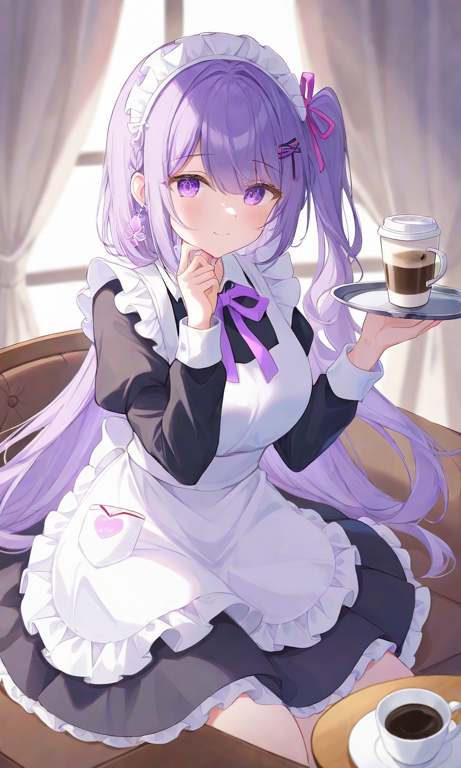

In [44]:
input_str = """
cute maid girl in oil painting style
""".strip()

_general_input, _character_input = split_input(input_str)
prompt_res, img = roll_image(_general_input, character=_character_input, rating="general")
display_results(prompt_res, img)